In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
)

df = pd.read_csv("C:/Users/VIGNEESH GPL/BigData/data2/encoded_dataset.csv")

print("Cleaned Dataset:")
print("Shape:", df.shape)
print(df.head())

Cleaned Dataset:
Shape: (11790, 15)
   studyhours  attendance  resources  extracurricular  motivation  internet  \
0          19          64          0                0           0         1   
1          19          64          0                0           0         1   
2          19          64          0                0           0         1   
3          19          64          0                1           0         1   
4          19          64          0                1           0         1   

   gender  age  learningstyle  onlinecourses  discussions  \
0       1   19              0              8            1   
1       1   23              1             16            0   
2       1   28              2             19            0   
3       1   19              0              8            1   
4       1   23              1             16            0   

   assignmentcompletion  edutech  stresslevel  finalgrade  
0                    59        0            1           3  
1 

In [10]:
# Define your target and feature columns
target_col = "finalgrade"  # dependent variable
X = df.drop(columns=[target_col])
y = df[target_col]

print("Target:", target_col)
print("Feature Columns:", X.columns.tolist())


Target: finalgrade
Feature Columns: ['studyhours', 'attendance', 'resources', 'extracurricular', 'motivation', 'internet', 'gender', 'age', 'learningstyle', 'onlinecourses', 'discussions', 'assignmentcompletion', 'edutech', 'stresslevel']


In [11]:
# Label encode categorical columns
label_encoders = {}
for col in X.select_dtypes(include=["object", "category"]).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Encode target column if necessary
if y.dtype == "object" or str(y.dtype) == "category":
    y_le = LabelEncoder()
    y = y_le.fit_transform(y)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set:", X_train.shape)
print("Testing set:", X_test.shape)


Training set: (9432, 14)
Testing set: (2358, 14)


In [13]:
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=5000, solver='lbfgs')
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"\n {name} Accuracy: {acc:.3f}")
    print(classification_report(y_test, y_pred))



 Decision Tree Accuracy: 0.867
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       645
           1       0.85      0.85      0.85       560
           2       0.87      0.87      0.87       606
           3       0.88      0.88      0.88       547

    accuracy                           0.87      2358
   macro avg       0.87      0.87      0.87      2358
weighted avg       0.87      0.87      0.87      2358


 Random Forest Accuracy: 0.889
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       645
           1       0.88      0.88      0.88       560
           2       0.91      0.90      0.91       606
           3       0.92      0.87      0.89       547

    accuracy                           0.89      2358
   macro avg       0.89      0.89      0.89      2358
weighted avg       0.89      0.89      0.89      2358


 Logistic Regression Accuracy: 0.265
              precision    r

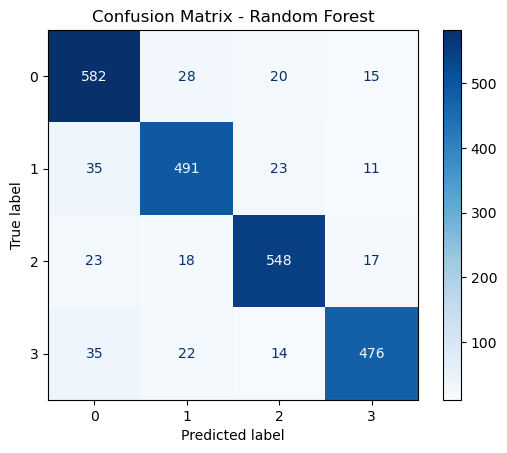

In [14]:
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()


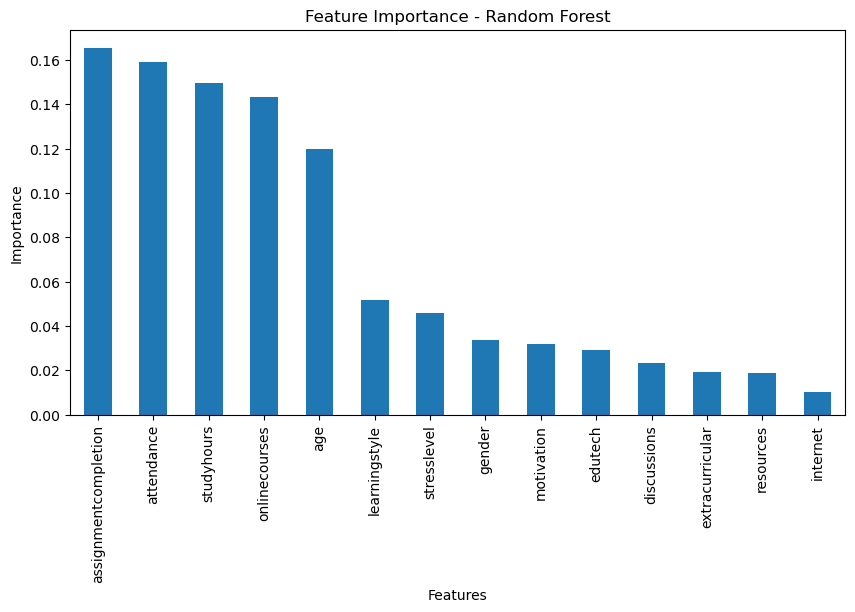

In [15]:
if hasattr(best_model, "feature_importances_"):
    importances = pd.Series(best_model.feature_importances_, index=X.columns)
    importances = importances.sort_values(ascending=False)
    plt.figure(figsize=(10, 5))
    importances.plot(kind="bar")
    plt.title(f"Feature Importance - {best_model_name}")
    plt.ylabel("Importance")
    plt.xlabel("Features")
    plt.show()


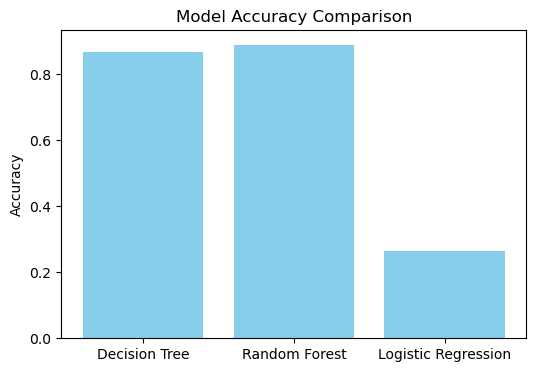

In [16]:
plt.figure(figsize=(6, 4))
plt.bar(results.keys(), results.values(), color="skyblue")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()
